## 001_simple_v1

This run uses a very simple model to get a rough idea for how difficult the problem is.

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [3]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../ef3b72ca'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [4]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

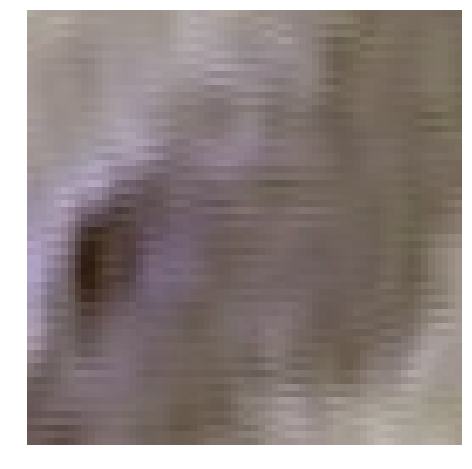

2


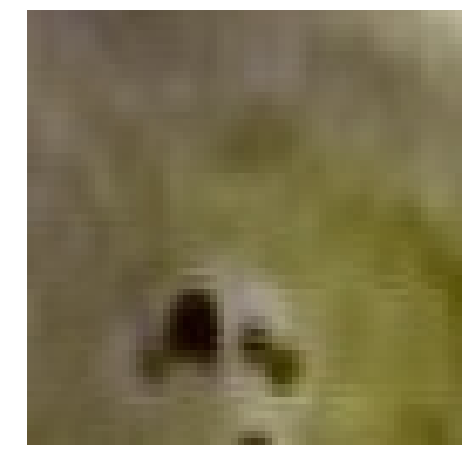

1


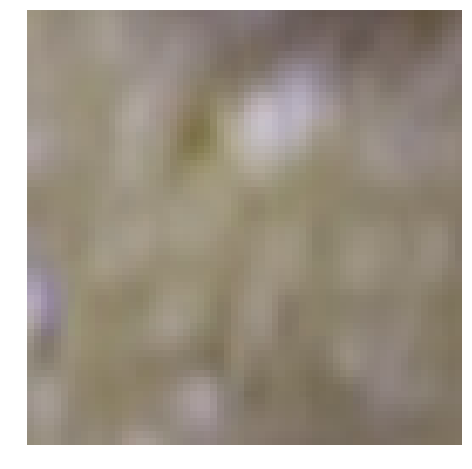

1


In [5]:
# INSPECT : look at class 1 = dysplasia and 2 = carcinoma tissues

render.plot_image(x_train[0])
print(y_train[0])

render.plot_image(x_train[1])
print(y_train[1])

render.plot_image(x_train[9])
print(y_train[9])


In [6]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [7]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [8]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_simple_v2_2class()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
__________

None

In [9]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2] [2 2 2 1 2 2 1 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 2 1 2 2 2
 2 2 2 1 2 2 1 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2] [1 1 1 2 1 1 1 2 2 2 1 2 2 2 2 1 2 1 2 1 1 1 2 2 2 2 2 1 1 1 2 2 1 2 2 2 1
 2 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 2 2 2 1 1 1 1 1 2 1 2 1 2 1 2 1 2 2 2 2 1
 1 2 1 1 1 1 1 2 1 2 1 2 1 1 1 2 2 2 1 2 1 1 2 1 1 1]


In [13]:
## RUN!!!

# parameters
batch_size = 16
epochs = 20

history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer()])

Train on 2799 samples, validate on 128 samples
Epoch 1/20
2799/2799 [==============================] - 5s 2ms/step - loss: 0.1669 - acc: 0.9296 - val_loss: 2.0225 - val_acc: 0.5859
Epoch 2/20
2799/2799 [==============================] - 5s 2ms/step - loss: 0.1428 - acc: 0.9359 - val_loss: 2.1394 - val_acc: 0.7500
Epoch 3/20
2799/2799 [==============================] - 5s 2ms/step - loss: 0.1223 - acc: 0.9453 - val_loss: 2.2490 - val_acc: 0.6562
Epoch 4/20
2799/2799 [==============================] - 5s 2ms/step - loss: 0.1036 - acc: 0.9609 - val_loss: 2.1988 - val_acc: 0.7656
Epoch 5/20
2799/2799 [==============================] - 5s 2ms/step - loss: 0.0856 - acc: 0.9670 - val_loss: 2.6483 - val_acc: 0.4766
Epoch 6/20
2799/2799 [==============================] - 5s 2ms/step - loss: 0.0777 - acc: 0.9716 - val_loss: 2.8226 - val_acc: 0.6211
Epoch 7/20
2799/2799 [==============================] - 5s 2ms/step - loss: 0.0801 - acc: 0.9696 - val_loss: 2.6185 - val_acc: 0.6641
Epoch 8/20
2799

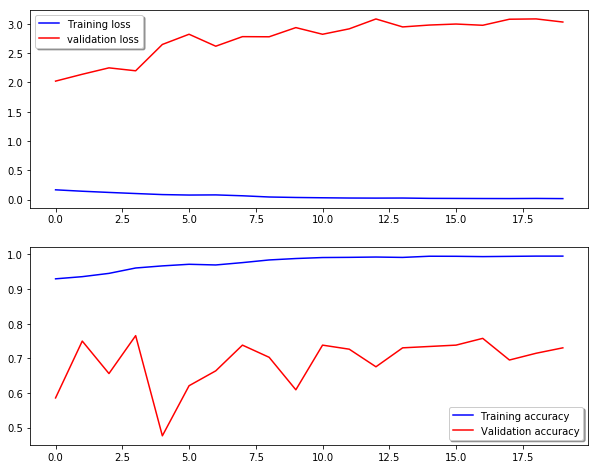

Precision (specificity): 46.469%
Recall (sensitivity): 49.024%
Accuracy: 43.455%
F1: 34.968%


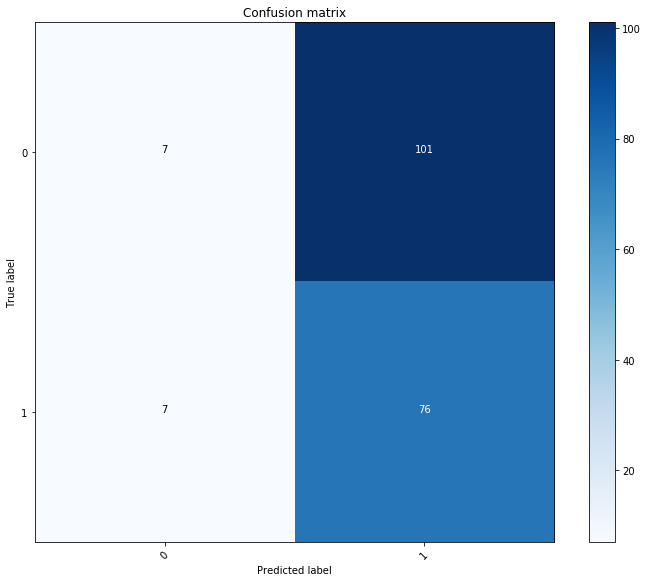

In [14]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [15]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(test_data_reader, model, test_dir, norm_data=(m, std))
analysis.contour_statistics(test_data_reader, model, test_dir, norm_data=(m, std))

hgv-2cdb69f6 [0.00162087 0.99712616] 0
mdi-9abd4637 [0.14286077 0.85710424] 1
mdi-9abd4637 [0.15195392 0.8524123 ] 1
odi-556875fe [6.3308876e-06 9.9999475e-01] 0


In [ ]:
model.save('model_001_no_reg.h5')